# Research Question:
### What are the most influential variables on the severity of accidents?

Useful Paper:
    https://www.sciencedirect.com/science/article/pii/S2590198223000611

In [1]:
#Display Spark Output in scrollable format within jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
#Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import holidays
from datetime import datetime, timezone
from pyspark.ml.classification import RandomForestClassifier, BinaryLogisticRegressionSummary
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Load Data

In [4]:
#Instantiate Spark Session
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())
spark.sparkContext.setLogLevel("ERROR") #supress warnings

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/05 15:32:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Read in Dataset
df = spark.read.parquet("data/final_dataset_binary.parquet")
df.show(5)

+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+
|Temperature|Humidity|Pressure|Visibility|Wind_Speed|Precipitation|Weekday|Rush_Hour|Rain|Snow|    SeasonVec|Astronomical_TwilightIndex|Interstate_Indicator|Sex_ratio|Percent_Age_65_over|MedianIncome|Urban_Ratio|Traffic_Interference|Traffic_Intersection|Destination|Severity_Binary|Percent_Age_15-24|
+-----------+--------+--------+----------+----------+-------------+-------+---------+----+----+-------------+--------------------------+--------------------+---------+-------------------+------------+-----------+--------------------+--------------------+-----------+---------------+-----------------+
|         21|      85|      30|         1|        10|            0|      1|        1|   0|   1|(3

# Sampling

In [6]:
# Undersample each class by 80% of the smallest class
rows = df.count()
cts = df.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / rows)*100)
cts.show()

sample = (cts.select("count").rdd.min()[0])*0.8

class0 = sample/(cts.select("count").where(cts.Severity_Binary == '0').rdd.min()[0])
class1 = sample/(cts.select("count").where(cts.Severity_Binary == '1').rdd.min()[0])

# Split Data by Class - Downsampling

# Create a temporary view to use SQL
df.createOrReplaceTempView("data_view")

# Calculate fractions for each class
#fractions = df.groupBy("Severity").count().rdd.map(lambda row: (row[0], 0.8)).collectAsMap() #samples 80% of each class
fractions = {0: class0, 1: class1} #downsample each class to 80% of the smallest class

# Use stratified sampling to maintain class distribution
train_data = df.sampleBy("Severity_Binary", fractions, seed=42)
test_data = df.subtract(train_data)

+---------------+-------+------------------+
|Severity_Binary|  count|           percent|
+---------------+-------+------------------+
|              1|1302620|18.537867702623352|
|              0|5724186| 81.46213229737664|
+---------------+-------+------------------+



In [7]:
# Print Overall % Sampled from DF
print(train_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
train_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / train_data.count())*100).show()

29.68448253730073
+---------------+-------+-----------------+
|Severity_Binary|  count|          percent|
+---------------+-------+-----------------+
|              1|1042070| 49.9585065423509|
|              0|1043801|50.04149345764911|
+---------------+-------+-----------------+



In [8]:
# Print Overall % Sampled from DF
print(test_data.count()/df.count()*100)

# Print % Sampled for each class within Train Data
test_data.groupBy("Severity_Binary").count().withColumn('percent', (F.col('count') / test_data.count())*100).show()

54.53338259231862


+---------------+-------+-----------------+
|Severity_Binary|  count|          percent|
+---------------+-------+-----------------+
|              1| 233338|6.089267749751759|
|              0|3598617|93.91073225024824|
+---------------+-------+-----------------+



# Modeling

In [9]:
# Select all features except target variable
feature_list = []
for col in df.columns:
    if col == 'Severity_Binary':
        continue
    else:
        feature_list.append(col)      
        
# Vectorize Features
assembler = VectorAssembler(inputCols=feature_list, outputCol='features')

In [10]:
feature_list

['Temperature',
 'Humidity',
 'Pressure',
 'Visibility',
 'Wind_Speed',
 'Precipitation',
 'Weekday',
 'Rush_Hour',
 'Rain',
 'Snow',
 'SeasonVec',
 'Astronomical_TwilightIndex',
 'Interstate_Indicator',
 'Sex_ratio',
 'Percent_Age_65_over',
 'MedianIncome',
 'Urban_Ratio',
 'Traffic_Interference',
 'Traffic_Intersection',
 'Destination',
 'Percent_Age_15-24']

In [12]:
# Create a RandomForestClassifier
rf = RandomForestClassifier(labelCol="Severity_Binary", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [7,9,10,11,12]) \
    .addGrid(rf.maxDepth, [3,4,5,6,7]) \
    .build()

# Create a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1.0),
                          numFolds=5)

# Fit the model
cvModel = crossval.fit(train_data)

# Make predictions on the test set
predictions = cvModel.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction", metricName="truePositiveRateByLabel", metricLabel=1.0)
recall = evaluator.evaluate(predictions)
print("Recall: ", recall)

# Get and save the best model
bestModel = cvModel.bestModel
bestModel.save("best_rf_model")
print(bestModel.stages[-1]._java_obj.paramMap()) 

Recall:  0.6630938809795233
{
	RandomForestClassifier_77d3a07912e0-featuresCol: features,
	RandomForestClassifier_77d3a07912e0-labelCol: Severity_Binary,
	RandomForestClassifier_77d3a07912e0-maxDepth: 5,
	RandomForestClassifier_77d3a07912e0-numTrees: 12
}


## Load Saved Best Model

In [13]:
# Load the saved best model
loadedCvModel = PipelineModel.load("best_rf_model")

## Evaluation Metrics

Weighted Precision: 0.9163423657234898
Weighted Recall: 0.6675798645860925
Weighted F1 Score: 0.7542774429721361
Accuracy: 0.6675798645860925


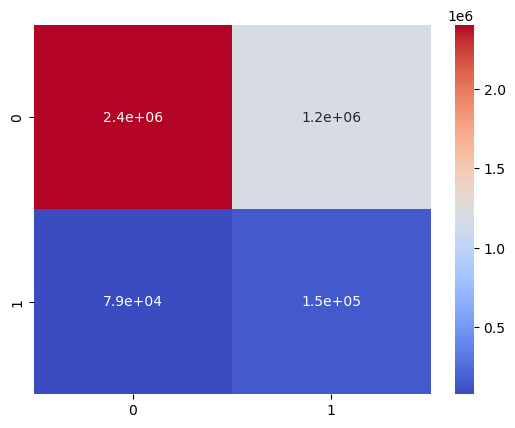

Area Under ROC: 0.665482310661136


In [14]:
# Further Metrics on Best Model
pred = loadedCvModel.transform(test_data)

#Evaluate (Confusion Matrix, Accuracy, Weighted Precision, Recall, and F1 Score)
predictionAndLabels = pred.select("prediction", "Severity_Binary")
rdd = predictionAndLabels.rdd.map(lambda x: tuple(map(float, x)))
multi_metrics = MulticlassMetrics(rdd)

# Get precision, recall, and F1-score for each class
print(f'Weighted Precision: {multi_metrics.weightedPrecision}') #would expect to be good when test sample has high majority 0 class
print(f'Weighted Recall: {multi_metrics.weightedRecall}')
print(f'Weighted F1 Score: {multi_metrics.weightedFMeasure()}') #would like to optimize this (balance of precision and recall)
print(f'Accuracy: {multi_metrics.accuracy}') #could be skewed with imbalanced test set

# Plot confusion matrix
cf = multi_metrics.confusionMatrix().toArray()
cf_df = pd.DataFrame(cf, columns=['0', '1'])
sns.heatmap(cf_df, annot=True, cmap="coolwarm")
plt.show()

# AUC Score
binary_metrics = BinaryClassificationMetrics(rdd)
auc = binary_metrics.areaUnderROC
print("Area Under ROC:", auc)

## Feature Importance

In [15]:
feature_importances = cvModel.bestModel.stages[-1].featureImportances

# Create a mapping between feature names and their importance scores
feature_importance_dict = {}
feature_names = assembler.getInputCols()
for i, feature_name in enumerate(feature_names):
    feature_importance_dict[feature_name] = feature_importances[i]

# Sort the feature importance dictionary by score in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature_name, importance_score in sorted_feature_importances:
    print(f"{feature_name}: {importance_score}")

Percent_Age_65_over: 0.49053950937053264
Percent_Age_15-24: 0.1568511845354934
Wind_Speed: 0.12192147010651161
Traffic_Intersection: 0.06245084964341772
SeasonVec: 0.0358147632185103
Pressure: 0.03061490818743745
Urban_Ratio: 0.00832455958453174
Traffic_Interference: 0.007966156344297039
Destination: 0.006340086373784106
Temperature: 0.005229160920100125
Sex_ratio: 0.004485786438812378
MedianIncome: 0.0034302707307557324
Astronomical_TwilightIndex: 0.0032794242373479455
Snow: 0.0026291722024928367
Weekday: 0.002409554534129293
Interstate_Indicator: 0.001191761964198162
Visibility: 0.001017085438089482
Rain: 0.0005061361609846139
Humidity: 0.00016550159211961777
Rush_Hour: 5.4202129400719564e-05
Precipitation: 0.0


# Sensitivity Analysis

In [16]:
train_data_s = assembler.transform(train_data)
test_data_s = assembler.transform(test_data)

# Define parameter ranges
param_ranges = {
    "maxDepth": [3,4,5,6],
    "numTrees": [3,4,5,6]
}

# Create an evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Severity_Binary", predictionCol="prediction")

# Perform sensitivity analysis
results = []
for maxDepth in param_ranges["maxDepth"]:
    for numTrees in param_ranges["numTrees"]:
        # Create a logistic regression model
        gbt = RandomForestClassifier(labelCol="Severity_Binary", featuresCol="features", maxDepth=maxDepth, numTrees=numTrees)

        # Fit the model
        model = gbt.fit(train_data_s)

        # Make predictions
        predictions = model.transform(test_data_s)

        # Evaluate the model
        recall = evaluator.evaluate(predictions, {evaluator.metricName:"truePositiveRateByLabel", evaluator.metricLabel: 1.0})
        f1 = evaluator.evaluate(predictions, {evaluator.metricName:"f1"})
        accuracy = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})

        # Store the results
        results.append([maxDepth, numTrees, recall, f1, accuracy])

# Save and Print Results
sensitivity_analysis = pd.DataFrame(columns=['maxDepth', 'numTrees', 'recall', 'f1', 'accuracy'])
for i,result in enumerate(results):
    sensitivity_analysis.loc[i] = result
print(sensitivity_analysis)

    maxDepth  numTrees    recall        f1  accuracy
0        3.0       3.0  0.690175  0.713544  0.614608
1        3.0       4.0  0.579387  0.780308  0.703519
2        3.0       5.0  0.608439  0.773524  0.693921
3        3.0       6.0  0.559532  0.805949  0.740353
4        4.0       3.0  0.768092  0.633417  0.520430
5        4.0       4.0  0.623520  0.762931  0.679304
6        4.0       5.0  0.465865  0.846424  0.802454
7        4.0       6.0  0.558597  0.805738  0.740055
8        5.0       3.0  0.612189  0.741588  0.650556
9        5.0       4.0  0.601329  0.780634  0.703869
10       5.0       5.0  0.485562  0.840872  0.793534
11       5.0       6.0  0.602058  0.788128  0.714422
12       6.0       3.0  0.529558  0.822159  0.764580
13       6.0       4.0  0.532845  0.821236  0.763161
14       6.0       5.0  0.628967  0.767320  0.685305
15       6.0       6.0  0.567323  0.808788  0.744403
